In [45]:
%matplotlib inline
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pickle

In [2]:
w_dir = os.getcwd()
print(w_dir)
files = os.listdir()
print(files)
files.remove('.ipynb_checkpoints')
files.remove('test_set_master_guess_array.npy')
files.remove('Sparsity_summary_confusion_matrices.ipynb')
files.remove('test_set_cifar_labels.npy')
print(files)

/home/battleday/Academic/Berkeley/Superman/local/cifar10-human-experiments/confusion_matrices
['vgg_15_BN_64.npz', 'resnet_preact_bottleneck_164.npz', 'wrn_28_10_cutout16.npz', '.ipynb_checkpoints', 'resnext_29_8x64d.npz', 'shake_shake_26_2x64d_SSI_cutout16.npz', 'densenet_BC_100_12.npz', 'test_set_master_guess_array.npy', 'test_set_cifar_labels.npy', 'resnet_basic_110.npz', 'pyramidnet_basic_110_270.npz', 'Sparsity_summary_confusion_matrices.ipynb']
['vgg_15_BN_64.npz', 'resnet_preact_bottleneck_164.npz', 'wrn_28_10_cutout16.npz', 'resnext_29_8x64d.npz', 'shake_shake_26_2x64d_SSI_cutout16.npz', 'densenet_BC_100_12.npz', 'resnet_basic_110.npz', 'pyramidnet_basic_110_270.npz']


In [ ]:
ground_labels = np.int_(np.load('test_set_cifar_labels.npy'))
master_guess_array = np.load('test_set_master_guess_array.npy')
categories = ['plane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
print(files)

def file_loader(path):
    a = np.load(path)
    return a['labels'], a['outputs'], a['accuracy']

def hist_guesess(guess_array, num_c=10):
    out = np.empty((len(guess_array), num_c))
    
    for i, guess_list in enumerate(guess_array):
        out[i] = np.bincount(guess_list, minlength=num_c)
        
    return out

def top_1(hist_array):
    """Can be hist of softmax"""
    return np.argmax(hist_array, axis=1)

In [37]:
# make human matrices

guess_hist = hist_guesess(master_guess_array)
print(guess_hist.shape, guess_hist[:5])

guess_hist_softmax = guess_hist/np.sum(guess_hist, axis=1)[:, np.newaxis] # normalizes, so each row sums to one and mirror softmax

guess_top_1 = top_1(guess_hist)
print(guess_top_1.shape, guess_top_1[:5])

['vgg_15_BN_64.npz', 'resnet_preact_bottleneck_164.npz', 'wrn_28_10_cutout16.npz', 'resnext_29_8x64d.npz', 'shake_shake_26_2x64d_SSI_cutout16.npz', 'densenet_BC_100_12.npz', 'resnet_basic_110.npz', 'pyramidnet_basic_110_270.npz']
(10000, 10)
[3 8 8 0 6] [3 8 8 0 6]
(10000, 10) [[  0.   1.   1.  48.   0.   1.   0.   0.   0.   0.]
 [  0.   0.   1.   0.   0.   0.   0.   0.  50.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.  52.   0.]
 [ 38.   0.   8.   0.   1.   0.   1.   0.   2.   1.]
 [  0.   0.   1.   0.   0.   0.  50.   0.   0.   0.]]
(10000,) [3 8 8 0 6]


In [39]:
# confusion matrix code
def convert_gt_1d(gt_1d, nc=False):
    """Creates matrix of size len(gt_1d)=samples, num_classes"""
    print(gt_1d.shape)
    
    ns = gt_1d.shape[0]
    print('num samples: ', np.int(ns))
    
    if not nc:
        nc = np.int(len(set(gt_1d.flatten())))
        print('num classes: ', nc)
        
    new_mat = np.zeros((ns, nc))
    
    rows = np.arange(gt_1d.shape[0])
        
    new_mat[rows, gt_1d] +=1
    
    return new_mat
    

def conf_matrix(one_hot_array, ground_truths):
    """Expects an array to be samples by classes"""
    try:
        nc = one_hot_array.shape[1]
    except:
        one_hot_array = convert_gt_1d(one_hot_array)
        nc = one_hot_array.shape[1]
        
    cm = np.empty((nc, nc))
    for cat in np.arange(nc):
        cm[cat] = np.sum(one_hot_array[np.where(ground_truths==cat)[0]], axis = 0)
    
    np.fill_diagonal(cm, 0)
    return cm

In [47]:
def dict_saver(model, di, s_dir):
    with open(s_dir + '/' + model + '_all_cms.p', 'wb') as pfile:
        pickle.dump(di, pfile)

s_dir = os.path.join(w_dir, 'matrices')
#print(s_dir)
if not os.path.exists(s_dir):
    os.mkdir(s_dir)
    
temp_d = {}
temp_d['cm_raw'] = conf_matrix(guess_hist, ground_labels)
temp_d['softmax'] = conf_matrix(guess_hist_softmax, ground_labels)
temp_d['gt'] = conf_matrix(guess_top_1, ground_labels)

dict_saver('Human', temp_d, s_dir)

for model_file in files:
    print(model_file)
    t_labs, t_outs, t_acc = file_loader(model_file)
    temp_d = {}
    temp_d['softmax'] = conf_matrix(t_outs, ground_labels)
    temp_d['gt'] = conf_matrix(top_1(t_outs), ground_labels)
    dict_saver(model_file.split('.')[0], temp_d, s_dir)

(10000,)
num samples:  10000
num classes:  10
vgg_15_BN_64.npz
(10000,)
num samples:  10000
num classes:  10
resnet_preact_bottleneck_164.npz
(10000,)
num samples:  10000
num classes:  10
wrn_28_10_cutout16.npz
(10000,)
num samples:  10000
num classes:  10
resnext_29_8x64d.npz
(10000,)
num samples:  10000
num classes:  10
shake_shake_26_2x64d_SSI_cutout16.npz
(10000,)
num samples:  10000
num classes:  10
densenet_BC_100_12.npz
(10000,)
num samples:  10000
num classes:  10
resnet_basic_110.npz
(10000,)
num samples:  10000
num classes:  10
pyramidnet_basic_110_270.npz
(10000,)
num samples:  10000
num classes:  10


In [ ]:
def cm_fig(cm, model, labels, s_dir=False):
    fig, ax = plt.subplots(figsize = (10, 10))
    ax.set_title('Confusion matrix: {0}'.format(model), fontsize = 20)
    ax.set_xlabel('Chosen', fontsize = 15)
    ax.set_ylabel('Ground truth', fontsize = 15)

    cax = ax.matshow(cm, cmap='Reds', interpolation = 'nearest')
    cbar = fig.colorbar(cax)
    #print(ax.get_xticks())
    ax.xaxis.set_ticks(np.arange(10))
    #print(ax.get_xticks())
    ax.yaxis.set_ticks(np.arange(10))

    ax.set_xticklabels(labels)

    ax.set_yticklabels(labels)
    
    if s_dir:
        plt.savefig(s_dir + '/' + model + '_confusion_matrix.png', bbox_inches="tight")

(10000,)
num samples:  10000
num classes:  10
[3 8 8] [[ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]]


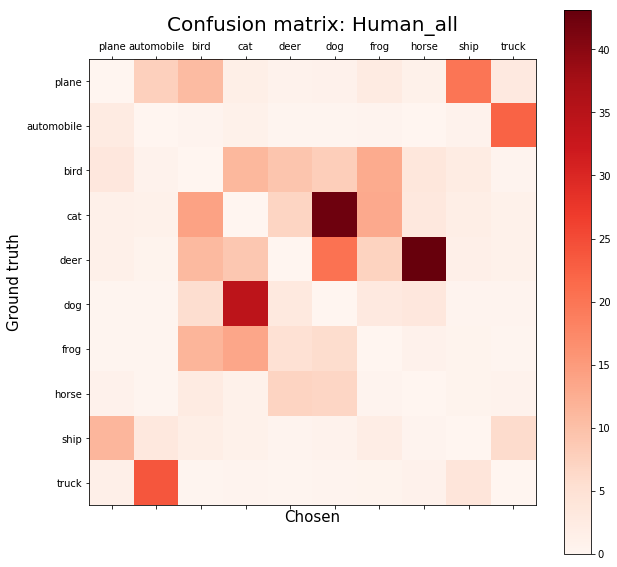

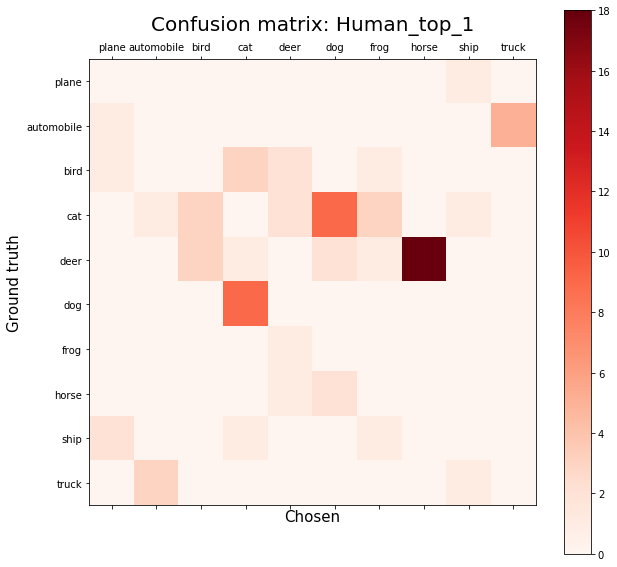

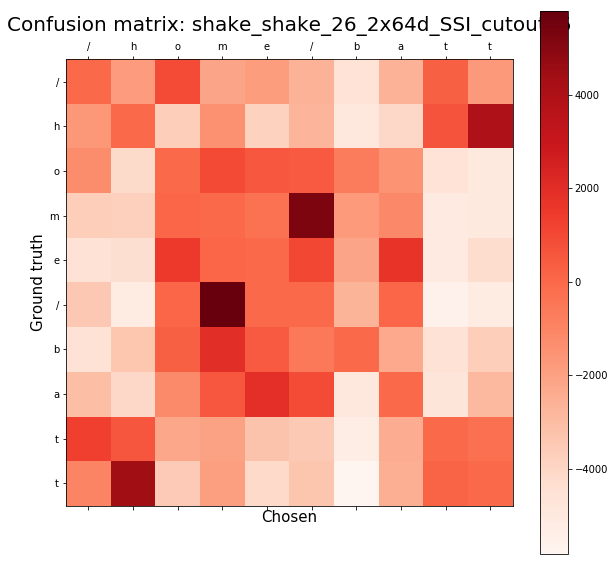

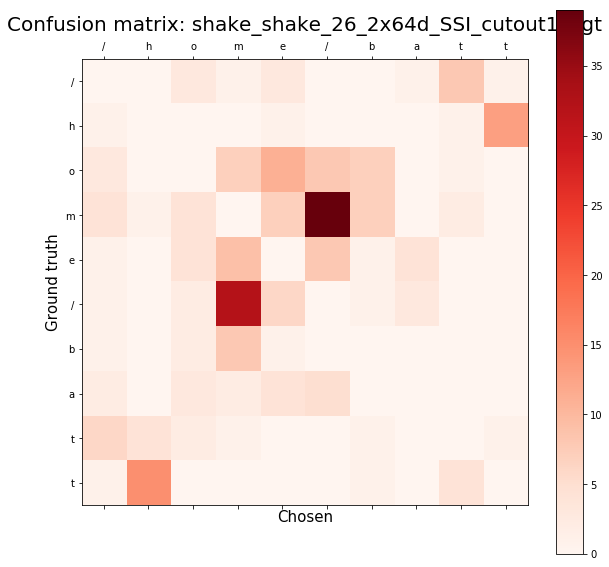

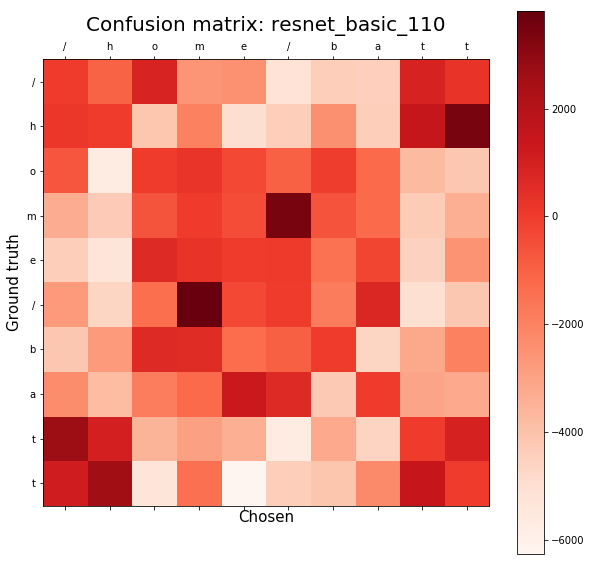

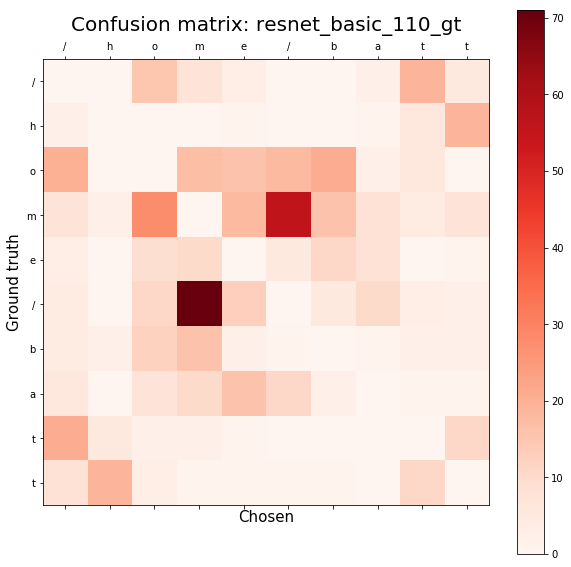

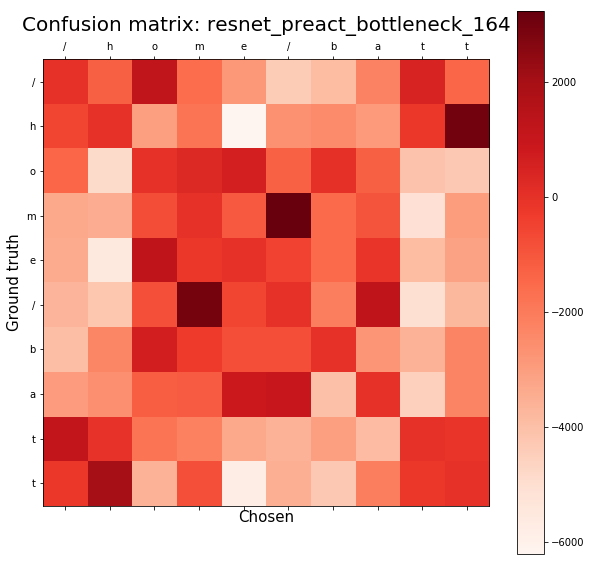

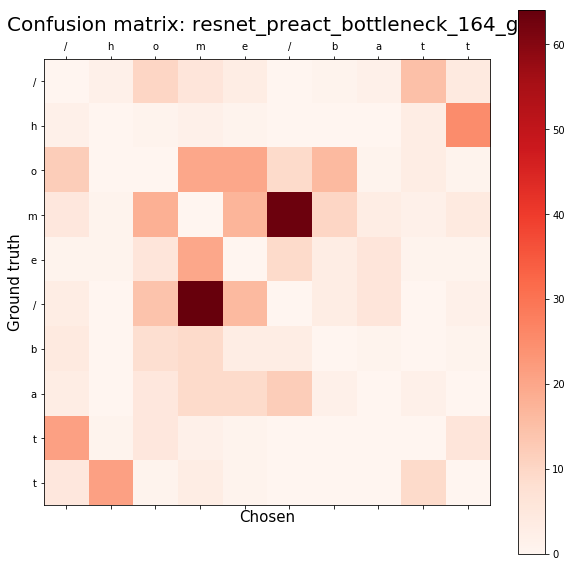

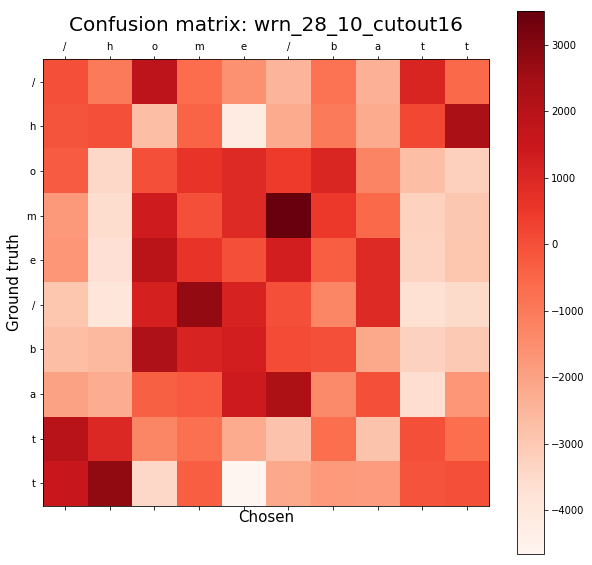

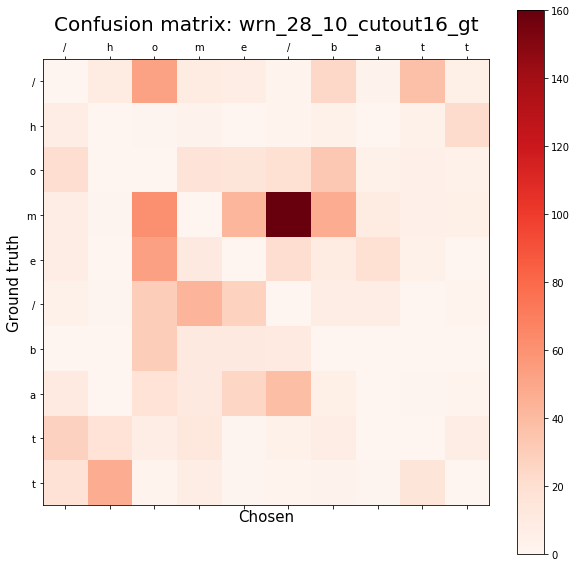

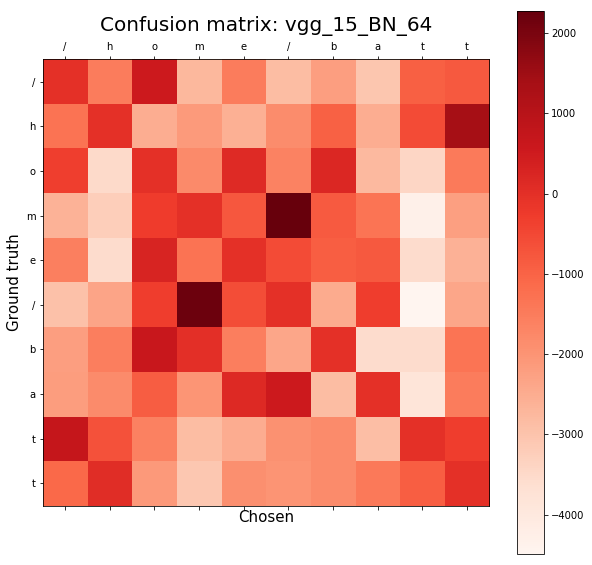

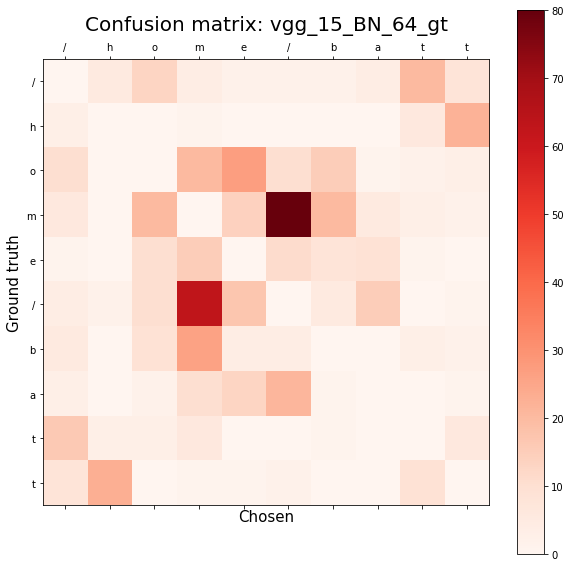

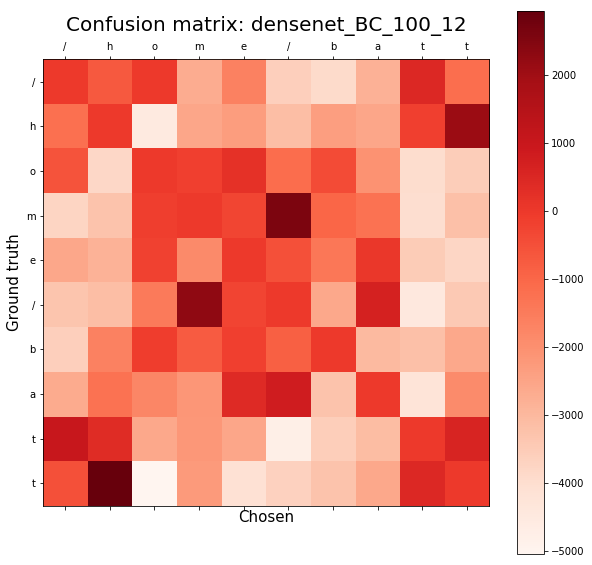

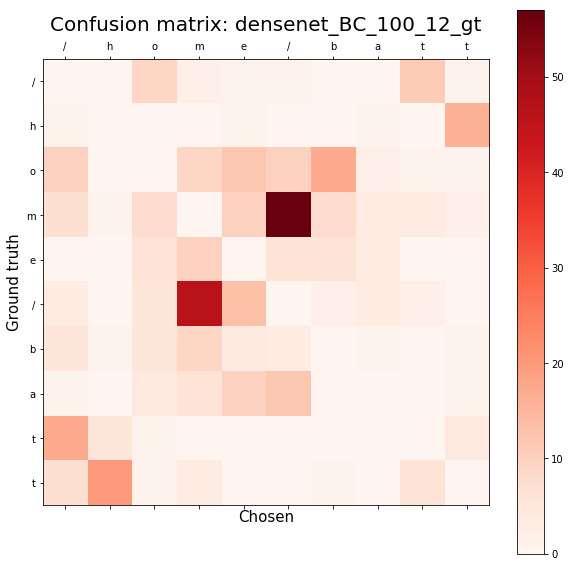

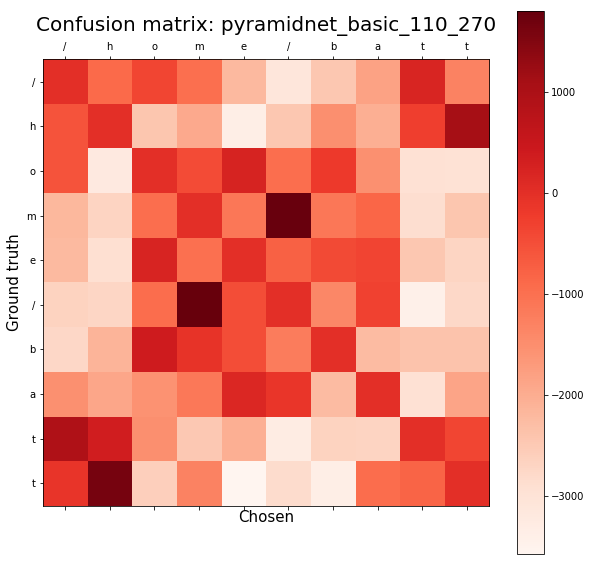

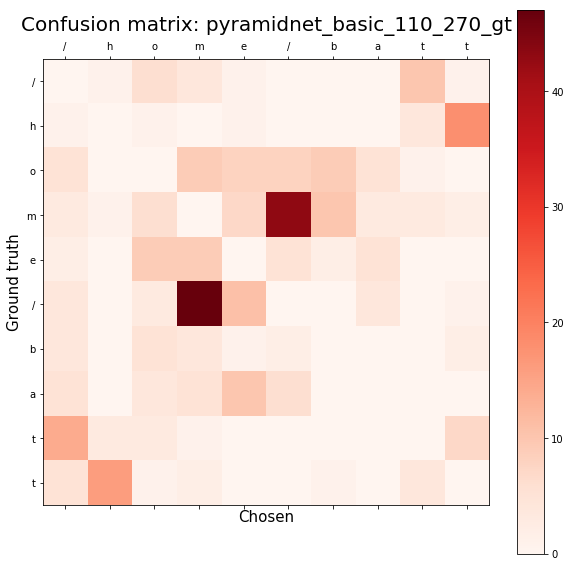

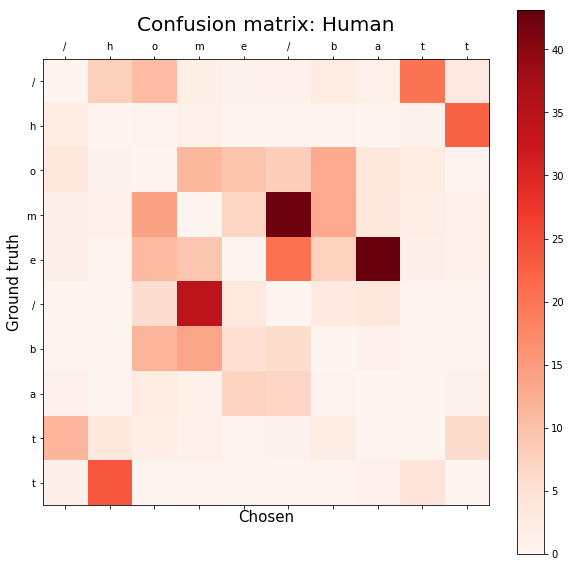

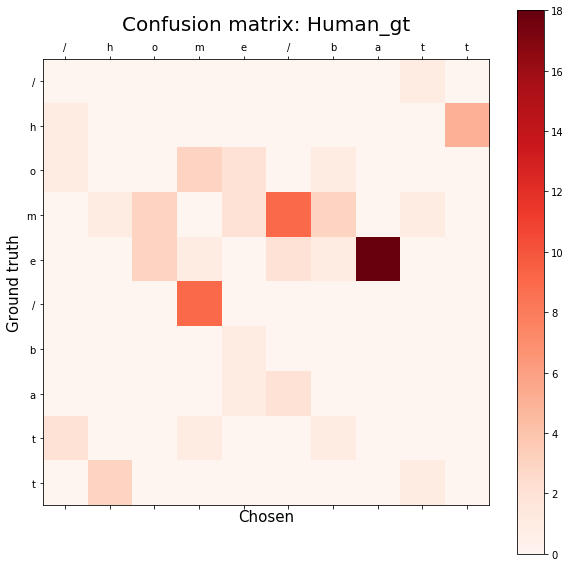

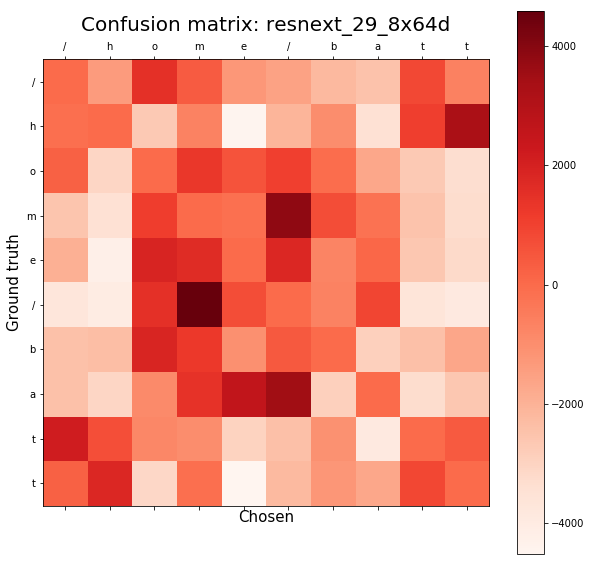

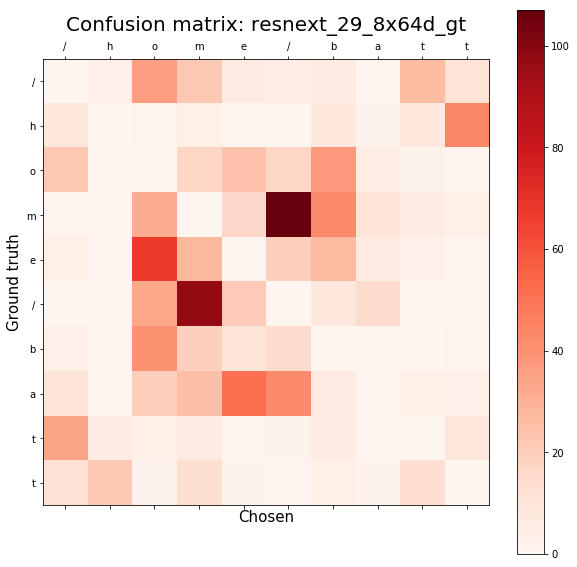

In [53]:
def dict_loader(path):
    with open(path, 'rb') as pfile:
        return pickle.load(pfile)

cm_files = os.listdir(w_dir + '/matrices')

for file in cm_files:
    di = dict_loader(w_dir + '/matrices/' + file)
    model_name = file.split('_a')[0]
    cm_fig(di['softmax'], model_name, w_dir + '/figures/' + model_name)
    cm_fig(di['gt'], model_name + '_gt', w_dir + '/figures/' + model_name + '_gt')

